In [30]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [31]:
########  パラメータ  #############
nqubit = 3 ## qubitの数
c_depth = 3 ## circuitの深さ
time_step = 0.77  ## ランダムハミルトニアンによる時間発展の経過時間

## [x_min, x_max]のうち, ランダムにnum_x_train個の点をとって教師データとする.
x_min = - 1.; x_max = 1.;
num_x_train = 50

## 学習したい1変数関数
func_to_learn = lambda x: np.sin(x*np.pi)

## 乱数のシード
random_seed = 0
## 乱数発生器の初期化
np.random.seed(random_seed)

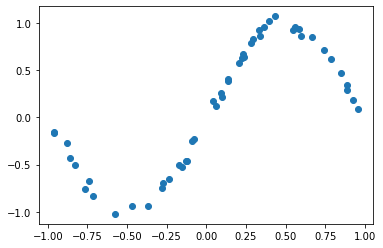

In [32]:
#### 教師データを準備
x_train = x_min + (x_max - x_min) * np.random.rand(num_x_train)
y_train = func_to_learn(x_train)

# 現実のデータを用いる場合を想定し、きれいなsin関数にノイズを付加
mag_noise = 0.05
y_train = y_train + mag_noise * np.random.randn(num_x_train)

plt.plot(x_train, y_train, "o"); plt.show()

In [33]:
# 初期状態の作成
from qulacs import QuantumState, QuantumCircuit

state = QuantumState(nqubit) # 初期状態 |000>
state.set_zero_state()
print(state.get_vector())

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [34]:
# xをエンコードするゲートを作成する関数
def U_in(x):
    U = QuantumCircuit(nqubit)

    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)

    return U

In [35]:
# 入力状態を試す
x = 0.1 # 適当な値
U_in(x).update_quantum_state(state) # U_in|000>の計算
print(state.get_vector())

[-6.93804351e-01+7.14937415e-01j -3.54871219e-02-3.51340074e-02j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
 -3.54871219e-02-3.51340074e-02j  1.77881430e-03-1.76111422e-03j
  1.77881430e-03-1.76111422e-03j  8.73809020e-05+9.00424970e-05j]


In [36]:
## 基本ゲート
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix()
Z_mat = Z(0).get_matrix()

In [37]:
## fullsizeのgateをつくる関数.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...] を受け取り,
    関係ないqubitにIdentityを挿入して
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    という(2**nqubit, 2**nqubit)行列をつくる.
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## 1-qubit gateを並べてnp.kronでreduceする
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## 何もないsiteはidentity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)

In [38]:
#### ランダム磁場・ランダム結合イジングハミルトニアンをつくって時間発展演算子をつくる
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## -1~1の乱数
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## 対角化して時間発展演算子をつくる. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT


In [39]:
time_evol_op.shape

(8, 8)

In [40]:
# qulacsのゲートに変換しておく
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

In [41]:
from qulacs import ParametricQuantumCircuit

In [42]:
# output用ゲートU_outの組み立て&パラメータ初期値の設定
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

In [43]:
# パラメータthetaの初期値のリストを取得しておく
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]

In [44]:
theta_init

[6.007250646127814,
 4.046309757767312,
 2.663159813474645,
 3.810080933381979,
 0.12059442161498848,
 1.8948504571449056,
 4.14799267096281,
 1.8226113595664735,
 3.88310546309581,
 2.6940332019609157,
 0.851208649826403,
 1.8741631278382846,
 3.5811951525261123,
 3.7125630518871535,
 3.6085919651139333,
 4.104181793964002,
 4.097285684838374,
 2.71068197476515,
 5.633168398253273,
 2.309459341364396,
 2.738620094343915,
 5.6041197193647925,
 5.065466226710866,
 4.4226624059922806,
 0.6297441057449945,
 5.777279648887616,
 4.487710439107831]

In [45]:
# パラメータthetaを更新する関数
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

In [46]:
# オブザーバブルZ_0を作成
from qulacs import Observable
obs = Observable(nqubit)
obs.add_operator(2.,'Z 0') # オブザーバブル2 * Zを設定。ここで2を掛けているのは、最終的な<Z>の値域を広げるためである。未知の関数に対応するためには、この定数もパラメータの一つとして最適化する必要がある。


In [47]:
obs.get_expectation_value(state)

1.9899748742132415

In [48]:
# 入力x_iからモデルの予測値y(x_i, theta)を返す関数
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # 入力状態計算
    U_in(x).update_quantum_state(state)

    # 出力状態計算
    U_out.update_quantum_state(state)

    # モデルの出力
    res = obs.get_expectation_value(state)

    return res

In [49]:
# cost function Lを計算
def cost_func(theta):
    '''
    theta: 長さc_depth * nqubit * 3のndarray
    '''
    # U_outのパラメータthetaを更新
#     global U_out
    set_U_out(theta)

    # num_x_train個のデータについて計算
    y_pred = [qcl_pred(x, U_out) for x in x_train]

    # quadratic loss
    L = ((y_pred - y_train)**2).mean()

    return L

In [50]:
cost_func(theta_init)

1.3889259316193527

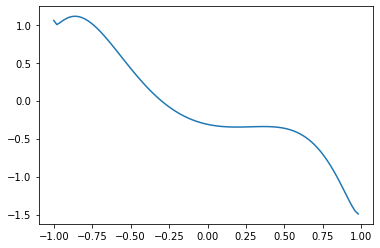

In [51]:
# パラメータthetaの初期値のもとでのグラフ
xlist = np.arange(x_min, x_max, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

In [52]:
from scipy.optimize import minimize

In [53]:
%%time
# 学習 (筆者のPCで1~2分程度かかる)
result = minimize(cost_func, theta_init, method='Nelder-Mead')

CPU times: user 19.8 s, sys: 26.3 s, total: 46.1 s
Wall time: 22.5 s


In [54]:
# 最適化後のcost_functionの値
result.fun

0.003987076559624735

In [55]:
# 最適化によるthetaの解
theta_opt = result.x
print(theta_opt)

[7.17242144 5.4043736  1.27744316 3.09192904 0.13144047 2.13757354
 4.58470259 2.01924008 2.96107066 2.91843537 1.0609229  1.70351774
 6.41114609 6.25686828 2.41619471 3.69387805 4.07551328 1.47666316
 3.4108701  2.28524042 1.75253621 4.6842948  1.81764827 9.01124549
 0.83624882 6.67990523 2.83779858]


In [56]:
# U_outに最適化されたthetaを代入
set_U_out(theta_opt)

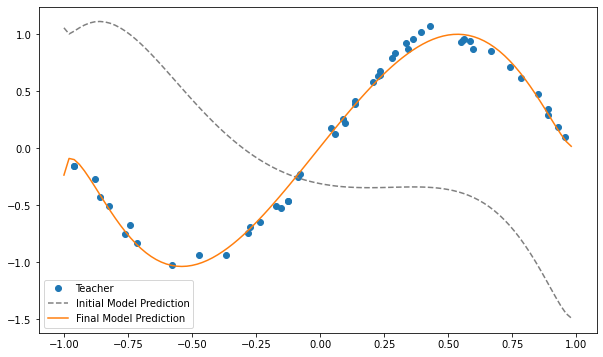

In [57]:
# プロット
plt.figure(figsize=(10, 6))

xlist = np.arange(x_min, x_max, 0.02)

# 教師データ
plt.plot(x_train, y_train, "o", label='Teacher')

# パラメータθの初期値のもとでのグラフ
plt.plot(xlist, y_init, '--', label='Initial Model Prediction', c='gray')

# モデルの予測値
y_pred = np.array([qcl_pred(x, U_out) for x in xlist])
plt.plot(xlist, y_pred, label='Final Model Prediction')

plt.legend()
plt.show()